In [4]:
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
import glob
from flower.task import Net
from lib.dataset_utils import *
import torch
# import dataloader
from torch.utils.data import DataLoader
from flower.task import Net, load_data, train, test
from flower.get_dataset import basic_collate_fn
# autoreload
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


lr = 0.001
cut_tp = None
extrap = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_centralized(train_dataset, test_dataset, time_steps_extrap):
    model = Net()
    dataset_name = "test"

    # train dataset 
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,
        collate_fn= lambda batch: basic_collate_fn(batch, time_steps_extrap, dataset_name, sample_tp, cut_tp, extrap, data_type = "train"))
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False,
        collate_fn= lambda batch: basic_collate_fn(batch, time_steps_extrap, dataset_name, sample_tp, cut_tp, extrap, data_type = "test"))

    # train
    loss_training = train(model, train_loader, test_loader, epochs, lr=lr, device=device, loss_per_epoch=True)

    avg_loss, nodesolves, metric_dict = loss_training
    train_loss = metric_dict["train_loss"]
    train_mse = metric_dict["train_mse"]
    val_loss = metric_dict["val_loss"]
    val_mse = metric_dict["val_mse"]

    print(f"Nodesolves: {nodesolves}")

    df = pd.DataFrame({"train_loss": train_loss, "train_mse": train_mse, "val_loss": val_loss, "val_mse": val_mse, "nodesolves": nodesolves})
    return df

def sample_timesteps(n_total_tp, max_t_extrap, distribution_type='uniform'):
    #time_steps = torch.linspace(0, max_t_extrap, n_total_tp)
    n_total_tp = n_total_tp - 1  # Adjust for the initial time step at 0.0
    if n_total_tp <= 0:
        raise ValueError("n_total_tp must be greater than 1 to sample time steps.")
    if distribution_type == 'uniform':
        # Sample uniformly distributed time steps
        distribution = uniform.Uniform(torch.Tensor([0.0]), torch.Tensor([max_t_extrap]))
        time_steps = distribution.sample(torch.Size([n_total_tp]))[:, 0]
    elif distribution_type == 'exponential':
        distribution = torch.distributions.Exponential(10.0)
        time_steps = distribution.sample((n_total_tp,))
        time_steps = time_steps / time_steps.max() * max_t_extrap
    elif distribution_type == 'lognormal':
        mean = random.uniform(0.0, 1.0)
        std = random.uniform(0.1, 2.0)
        distribution = torch.distributions.LogNormal(mean, std)
        time_steps = distribution.sample((n_total_tp,))
        time_steps = time_steps / time_steps.max() * max_t_extrap
    elif distribution_type == 'beta':
        left = 1.0
        right = 1.0
        a = random.uniform(left,right)
        b = random.uniform(left,right)
        distribution = torch.distributions.Beta(a, b)
        time_steps = distribution.sample((n_total_tp,))
        time_steps = time_steps * max_t_extrap

    time_steps = torch.cat((torch.Tensor([0.0]), time_steps))
    time_steps = torch.sort(time_steps)[0]
    return time_steps

def plot_timesteps(timesteps):
    plt.figure(figsize=(13, 1))
    plt.plot(time_steps.numpy(), np.zeros_like(time_steps.numpy()), 'o', label='Sampled Time Steps', markersize = 1)
    # add vlines for all time steps
    plt.vlines(time_steps.numpy(), -0.1, 0.1, colors='blue', linestyles='dashed', alpha=0.5)
    plt.title('Sampled Time Steps')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.axhline(0, color='gray', lw=0.5, ls='--')
    plt.legend()
    plt.grid()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
amp_start = 0.1
amp_end = 1.0 
freq_start =0.1
freq_end = freq_start
epochs = 2
batch_size = 3
sample_tp = 0.9
n_samples = 10
max_t_extrap = 2000
time_steps = sample_timesteps(n_total_tp= 100, max_t_extrap = max_t_extrap, distribution_type='uniform')


dataset, _ = get_dataset(amp_start, freq_start, time_steps, noise_weight=0.1, n_samples=n_samples)
amps = np.full((dataset.shape[0],), amp_start)
freqs = np.full((dataset.shape[0],), freq_start)
full_dataset = amps, freqs, dataset, time_steps
train_d, test_d = split_train_test_with_meta(full_dataset, train_fraq = 0.8)

df = run_centralized(train_d["data"], test_d["data"], time_steps_extrap=time_steps)
#plot_timesteps(time_steps)
#plt.plot(time_steps, test_d["data"][0], marker='o', markersize=3, label='Train Data')

Model configuration: {'dataset_name': 'freq_amp_decay_maxfreq_0.1', 'data_folder': '../data/freq_amp_decay_maxfreq_0.1', 'sample_tp': '0.5', 'lr': '0.01', 'lrdecay': '0.99', 'cut_tp': None, 'batch_size': '50', 'extrap': False, 'obsrv_std': '0.01', 'poisson': False, 'rec_layers': '1', 'gen_layers': '1', 'units': '100', 'gru_units': '100', 'latents': '10', 'rec_dims': '20', 'z0_encoder': 'odernn', 'train_classif_w_reconstr': False, 'classif': False, 'linear_classif': False, 'classif_per_tp': False, 'n_labels': '1', 'input_dim': '1', 'aggregation': 'FedAvg', 'storeweights': False, 'alpha': '0.5', 'localepochs': '3', 'serverrounds': '3', 'fractionfit': '1.0', 'fractionevaluate': '1.0', 'device': 'cpu', 'use_wandb': False, 'gradientclipping': False, 'decay_onset': '100'}
20
2
100
False
Nodesolves: [584.0, 594.0]


In [ ]:
# create a vector of the size of ecg100 for timesteps


array([    0.        ,   204.08163265,   408.16326531,   612.24489796,
         816.32653061,  1020.40816327,  1224.48979592,  1428.57142857,
        1632.65306122,  1836.73469388,  2040.81632653,  2244.89795918,
        2448.97959184,  2653.06122449,  2857.14285714,  3061.2244898 ,
        3265.30612245,  3469.3877551 ,  3673.46938776,  3877.55102041,
        4081.63265306,  4285.71428571,  4489.79591837,  4693.87755102,
        4897.95918367,  5102.04081633,  5306.12244898,  5510.20408163,
        5714.28571429,  5918.36734694,  6122.44897959,  6326.53061224,
        6530.6122449 ,  6734.69387755,  6938.7755102 ,  7142.85714286,
        7346.93877551,  7551.02040816,  7755.10204082,  7959.18367347,
        8163.26530612,  8367.34693878,  8571.42857143,  8775.51020408,
        8979.59183673,  9183.67346939,  9387.75510204,  9591.83673469,
        9795.91836735, 10000.        ])

In [183]:
import neurokit2 as nk
ecg100 = nk.ecg_simulate(duration=2, noise=1.0, heart_rate=290, sampling_rate=100, random_state=12, length = 10, heart_rate_std = 10, random_state_distort="legacy")
print(f"ECG100 shape: {ecg100.shape}")
time_steps_ecg100 = np.linspace(0, 1000, len(ecg100))
time_steps_ecg100 = torch.Tensor(time_steps_ecg100)
# make ecg100 tensor of shape (n_samples, n_tp, 1)
ecg100 = torch.tensor(ecg100, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)  # Add channel dimension
ecg100 = ecg100.permute(1, 0, 2)  # Change shape to (n_samples, 1, n_tp)
df = run_centralized(ecg100, ecg100, time_steps_extrap=time_steps_ecg100)

ECG100 shape: (10,)
Model configuration: {'dataset_name': 'freq_amp_decay_maxfreq_0.1', 'data_folder': '../data/freq_amp_decay_maxfreq_0.1', 'sample_tp': '0.5', 'lr': '0.01', 'lrdecay': '0.99', 'cut_tp': None, 'batch_size': '50', 'extrap': False, 'obsrv_std': '0.01', 'poisson': True, 'rec_layers': '1', 'gen_layers': '1', 'units': '100', 'gru_units': '100', 'latents': '10', 'rec_dims': '20', 'z0_encoder': 'odernn', 'train_classif_w_reconstr': False, 'classif': False, 'linear_classif': False, 'classif_per_tp': False, 'n_labels': '1', 'input_dim': '1', 'aggregation': 'FedAvg', 'storeweights': False, 'alpha': '0.5', 'localepochs': '3', 'serverrounds': '3', 'fractionfit': '1.0', 'fractionevaluate': '1.0', 'device': 'cpu', 'use_wandb': False, 'gradientclipping': False, 'decay_onset': '100'}
False
Nodesolves: [248.0, 170.0, 194.0, 158.0, 218.0]


In [153]:
nk.ecg_simulate

<function neurokit2.ecg.ecg_simulate.ecg_simulate(duration=10, length=None, sampling_rate=1000, noise=0.01, heart_rate=70, heart_rate_std=1, method='ecgsyn', random_state=None, random_state_distort='spawn', **kwargs)>

In [ ]:
df = run_centralized(train_d["data"], test_d["data"], time_steps_extrap=time_steps)
#plot_timesteps(time_steps)

plt.plot(time_steps, test_d["data"][0], marker='o', markersize=3, label='Train Data')

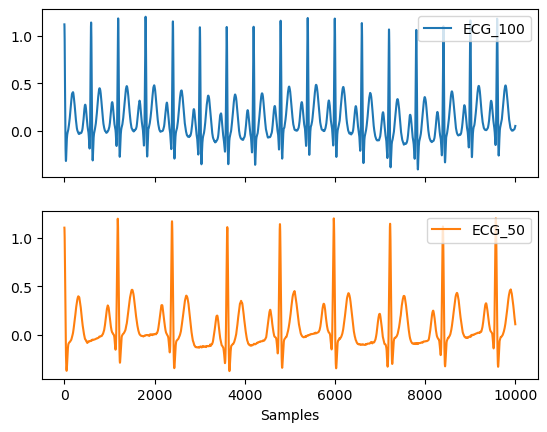

In [ ]:


ecg50 = nk.ecg_simulate(duration=10, noise=0.01, heart_rate=50)
# Visualize
ecg_df = pd.DataFrame({"ECG_100": ecg100, "ECG_50": ecg50})

nk.signal_plot(ecg_df, subplots=True)

In [ ]:
dat

,ECG_100,ECG_50
0,1.123108,1.102664
1,1.116994,1.098585
2,1.102063,1.089468
3,1.078450,1.075500
4,1.046777,1.056650
...,...,...
9995,0.041859,0.125879
9996,0.044013,0.122005
9997,0.046310,0.118202
9998,0.048768,0.114488


In [99]:
from lib.generate_timeseries import Periodic_1d
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = 10
epochs = 5
batch_size = 10
sample_tp = 0.9
n_samples = 10

def get_solves(max_t_extrap):
    time_steps = sample_timesteps(n_total_tp= 10, max_t_extrap = max_t_extrap, distribution_type='uniform')

    dataset_obj = Periodic_1d(
        init_freq = freq_start, init_amplitude = amp_start,
        final_amplitude = amp_end, final_freq = freq_end, 
        z0 = 1.)
    dataset = dataset_obj.sample_traj(time_steps, n_samples = 10, noise_weight = 0.0)
    dataset.shape
    time_steps.shape


    # dataset, _ = get_dataset(amp_start, freq_start, time_steps, noise_weight=0.1, n_samples=n_samples)
    amps = np.full((dataset.shape[0],), amp_start)
    freqs = np.full((dataset.shape[0],), freq_start)
    full_dataset = amps, freqs, dataset, time_steps
    train_d, test_d = split_train_test_with_meta(full_dataset, train_fraq = 0.8)
    # #
    #plt.plot(time_steps, train_d["data"][1], marker='o', markersize=3, label='Train Data')
    df = run_centralized(train_d["data"], test_d["data"], time_steps_extrap=time_steps)
    return df[["nodesolves"]].mean()

df_solves = pd.DataFrame()
for i in range(3500,10000, 500):
    solves = get_solves(i)
    df_solves = pd.concat([df_solves,
        pd.DataFrame({"max_t_extrap": i, "nodesolves": solves})], ignore_index=True)

df_solves


Model configuration: {'dataset_name': 'freq_amp_decay_maxfreq_0.1', 'data_folder': '../data/freq_amp_decay_maxfreq_0.1', 'sample_tp': '0.5', 'lr': '0.01', 'lrdecay': '0.99', 'cut_tp': None, 'batch_size': '50', 'extrap': False, 'obsrv_std': '0.01', 'poisson': True, 'rec_layers': '1', 'gen_layers': '1', 'units': '100', 'gru_units': '100', 'latents': '10', 'rec_dims': '20', 'z0_encoder': 'odernn', 'train_classif_w_reconstr': False, 'classif': False, 'linear_classif': False, 'classif_per_tp': False, 'n_labels': '1', 'input_dim': '1', 'aggregation': 'FedAvg', 'storeweights': False, 'alpha': '0.5', 'localepochs': '3', 'serverrounds': '3', 'fractionfit': '1.0', 'fractionevaluate': '1.0', 'device': 'cpu', 'use_wandb': False, 'gradientclipping': False, 'decay_onset': '100'}
False
Nodesolves: [620.0, 554.0, 674.0, 614.0, 566.0]
Model configuration: {'dataset_name': 'freq_amp_decay_maxfreq_0.1', 'data_folder': '../data/freq_amp_decay_maxfreq_0.1', 'sample_tp': '0.5', 'lr': '0.01', 'lrdecay': '0.9

AssertionError: 